# Курсовой проект

## Описание проекта
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

## Обзор данных<a class="anchor" id="course_project_review"></a>
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [522]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

%matplotlib inline
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [523]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

In [524]:
tfull = pd.read_csv(TRAIN_DATASET_PATH)

In [525]:
N = 5000
#train
train_full = tfull.iloc[:N,:].copy()
#test
test_full = tfull.iloc[N:,:-1].copy()
#key ans
test_full_ans = tfull.iloc[N:,-1].copy()

display(train_full.shape)
display(test_full.shape)

(5000, 17)

(2500, 16)

In [526]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_full.columns.drop(TARGET_NAME).tolist()
TEST_BASE_FEATURE_NAMES = test_full.columns.tolist()
NEW_FEATURE_NAMES = train_full.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [527]:
train_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,3941.0,1.358138e+06,8.412230e+05,164597.0,834651.00,1168158.0,1631644.00,9.338880e+06
Tax Liens,5000.0,3.000000e-02,2.590626e-01,0.0,0.00,0.0,0.00,6.000000e+00
Number of Open Accounts,5000.0,1.108300e+01,4.929723e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,5000.0,1.835710e+01,7.102891e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,5000.0,1.079269e+06,1.961283e+07,0.0,277139.50,487069.0,797676.00,1.304726e+09
Number of Credit Problems,5000.0,1.730000e-01,5.007206e-01,0.0,0.00,0.0,0.00,6.000000e+00
Months since last delinquent,2284.0,3.445184e+01,2.179906e+01,0.0,16.00,31.0,50.00,1.180000e+02
Bankruptcies,4989.0,1.198637e-01,3.526511e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,5000.0,1.211241e+07,3.221197e+07,11242.0,180119.50,308462.0,525882.50,1.000000e+08
Current Credit Balance,5000.0,2.922417e+05,3.318015e+05,0.0,112817.25,209323.0,362567.50,6.506797e+06


In [528]:
test_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,2002.0,1.382640e+06,8.533618e+05,216714.0,859811.75,1168528.5,1659787.75,10149344.0
Tax Liens,2500.0,3.040000e-02,2.951452e-01,0.0,0.00,0.0,0.00,7.0
Number of Open Accounts,2500.0,1.122680e+01,4.866625e+00,2.0,8.00,11.0,14.00,42.0
Years of Credit History,2500.0,1.823820e+01,6.919173e+00,4.3,13.60,17.0,22.00,51.0
Maximum Open Credit,2500.0,6.769239e+05,1.066010e+06,0.0,282012.50,466081.0,783706.00,26406996.0
Number of Credit Problems,2500.0,1.640000e-01,4.943701e-01,0.0,0.00,0.0,0.00,7.0
Months since last delinquent,1135.0,3.517709e+01,2.146659e+01,0.0,17.50,33.0,50.00,92.0
Bankruptcies,2497.0,1.117341e-01,3.360225e-01,0.0,0.00,0.0,0.00,4.0
Current Loan Amount,2500.0,1.139471e+07,3.134752e+07,21516.0,180246.00,311553.0,500010.50,99999999.0
Current Credit Balance,2500.0,2.850164e+05,2.880003e+05,0.0,115672.00,209399.0,354497.25,4209659.0


In [494]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                5000 non-null   object 
 1   Annual Income                 3941 non-null   float64
 2   Years in current job          4741 non-null   object 
 3   Tax Liens                     5000 non-null   float64
 4   Number of Open Accounts       5000 non-null   float64
 5   Years of Credit History       5000 non-null   float64
 6   Maximum Open Credit           5000 non-null   float64
 7   Number of Credit Problems     5000 non-null   float64
 8   Months since last delinquent  2284 non-null   float64
 9   Bankruptcies                  4989 non-null   float64
 10  Purpose                       5000 non-null   object 
 11  Term                          5000 non-null   object 
 12  Current Loan Amount           5000 non-null   float64
 13  Cur

In [495]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 5000 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2002 non-null   float64
 2   Years in current job          2388 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1135 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  

### Проверка значений базовых признаков
Функция _check_feature_values(df)_ выводит информацию о типе данных признака, количество пропусков, уникальные значения, определяет возможность преобразования float &#8594; int

In [496]:
def check_feature_values(df):
    FEATURE_NAMES = BASE_FEATURE_NAMES
    dataset_size = df.index.size
    features_to_int = []
    features_with_nans = {}
    for feature in FEATURE_NAMES:
        non_nan_count = df[feature].count()
        unique_values = df[feature].unique()
        if len(unique_values) > 20:
            unique_values_str = str(unique_values[:5]) + ' ... ' + str(unique_values[len(unique_values) - 5:])
        else:
            unique_values_str = str(unique_values)
        print(f"\033[1m{feature}\033[0m")
        print(f"\t\033[1mUnique values:\033[0m\n\t{unique_values_str}")
        print(f"\t\033[1mFeature not NaN size:\033[0m {non_nan_count}")
        print(f"\t\033[1mType of values:\033[0m {df.dtypes[feature]}")
        if non_nan_count == dataset_size:
            print(f"\033[95mПропусков нет\033[0m")
        elif non_nan_count / dataset_size > 0.9:
            print(f"\033[95mНемного пропусков\033[0m {dataset_size - non_nan_count}")
        else:
            print(f"\033[95mМного пропусков\033[0m {dataset_size - non_nan_count}")

        # Проверка float-значений на целые.
        # Если тип float, но при этом дробные части всех элементов равны 0, можно преобразовать в int
        int_flag = True

        if df.dtypes[feature] == np.float64 and dataset_size == non_nan_count:
            for i in df[feature]:
                try:      
                    if not pd.isna(i) and i != int(i):
                        int_flag = False
                        break
                except:
                    int_flag = False
        else:
            int_flag = False
        if int_flag:
            print(f"\033[92mПреобразовать в INT\033[0m")
            features_to_int.append(feature)

        # Формирование словаря признаков с пропусками
        if dataset_size != non_nan_count:
            features_with_nans[feature] = dataset_size - non_nan_count

        # Если признак состоит из 2 значений типа object, можно заменить их на 0 и 1
        if df.dtypes[feature] == np.object and len(unique_values) == 2:
            print(f"\033[94mПреобразовать значения категориального признака {feature} в 0 и 1\033[0m")
        print('*' * 50)
    return features_with_nans, features_to_int

In [497]:
# Тренировочный датасет
train_pass_features, train_features_to_int = check_feature_values(train_full)

Home Ownership
	Unique values:
	['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
	Feature not NaN size: 5000
	Type of values: object
Пропусков нет
**************************************************
Annual Income
	Unique values:
	[ 482087. 1025487.  751412.  805068.  776264.] ... [3676063. 1719063.  925547. 1158126.  986119.]
	Feature not NaN size: 3941
	Type of values: float64
Много пропусков 1059
**************************************************
Years in current job
	Unique values:
	[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']
	Feature not NaN size: 4741
	Type of values: object
Немного пропусков 259
**************************************************
Tax Liens
	Unique values:
	[0. 3. 1. 2. 4. 6. 5.]
	Feature not NaN size: 5000
	Type of values: float64
Пропусков нет
Преобразовать в INT
**************************************************
Number of Open Accounts
	Unique values:
	[11. 15.  8. 13. 12.] ... [43. 41.

In [498]:
# Тестовый датасет
test_pass_features, test_features_to_int = check_feature_values(test_full)

Home Ownership
	Unique values:
	['Rent' 'Home Mortgage' 'Own Home' 'Have Mortgage']
	Feature not NaN size: 2500
	Type of values: object
Пропусков нет
**************************************************
Annual Income
	Unique values:
	[1401782.  815233.  976068.  843030.  946523.] ... [2833185. 1257610.  402192. 1533984. 1878910.]
	Feature not NaN size: 2002
	Type of values: float64
Много пропусков 498
**************************************************
Years in current job
	Unique values:
	['4 years' '2 years' '10+ years' '8 years' '7 years' '5 years' '9 years'
 '1 year' '< 1 year' '3 years' nan '6 years']
	Feature not NaN size: 2388
	Type of values: object
Немного пропусков 112
**************************************************
Tax Liens
	Unique values:
	[0. 2. 1. 3. 6. 7. 4.]
	Feature not NaN size: 2500
	Type of values: float64
Пропусков нет
Преобразовать в INT
**************************************************
Number of Open Accounts
	Unique values:
	[12.  7.  5. 11. 19.] ... [37. 28. 

### Обзор целевого признака

In [499]:
train_full[TARGET_NAME].value_counts()

0    3617
1    1383
Name: Credit Default, dtype: int64

Данные разбалансированы

## Преобразование признаков

### Изменение типа признаков на int

Функция *f_features_to_int* преобразует признаки из списка features_to_int к типу int:

In [500]:
def f_features_to_int(df, df_name, features_to_int):
    print(f"\tПреобразование типа признаков для датасета \033[1m{df_name}\033[0m:")
    for feature in features_to_int:
        try:
            df[feature] = df[feature].astype(int)
            print(f"Значения признака \033[1m{feature}\033[0m преобразованы в int")
        except:
            print(f"Проблема с признаком {feature}:\n {i}")

In [501]:
f_features_to_int(train_full, 'train_full', train_features_to_int)
f_features_to_int(test_full, 'test_full', test_features_to_int)

	Преобразование типа признаков для датасета train_full:
Значения признака Tax Liens преобразованы в int
Значения признака Number of Open Accounts преобразованы в int
Значения признака Maximum Open Credit преобразованы в int
Значения признака Number of Credit Problems преобразованы в int
Значения признака Current Loan Amount преобразованы в int
Значения признака Current Credit Balance преобразованы в int
Значения признака Monthly Debt преобразованы в int
	Преобразование типа признаков для датасета test_full:
Значения признака Tax Liens преобразованы в int
Значения признака Number of Open Accounts преобразованы в int
Значения признака Maximum Open Credit преобразованы в int
Значения признака Number of Credit Problems преобразованы в int
Значения признака Current Loan Amount преобразованы в int
Значения признака Current Credit Balance преобразованы в int
Значения признака Monthly Debt преобразованы в int


### Изменение значений признаков

Признак "Years in current job" обладает числовыми значениями, но в каждом значении присутствует слово "year(s)". Предлагается оставить только числовые значения. Строки со значениями "10+ years" и  "< 1 year" преобразовать в 10 и 0

Функция _replace_year_to_num_ преобразовывает категориальные значения признака "Years in current job" в числовые int:

In [502]:
def replace_year_to_num(df):
    df.replace({'Years in current job': {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2, 
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10      
}}, inplace=True)

Преобразование признака "Years in current job" для обоих датасетов:

In [503]:
replace_year_to_num(train_full)
replace_year_to_num(test_full)

In [504]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                5000 non-null   object 
 1   Annual Income                 3941 non-null   float64
 2   Years in current job          4741 non-null   float64
 3   Tax Liens                     5000 non-null   int64  
 4   Number of Open Accounts       5000 non-null   int64  
 5   Years of Credit History       5000 non-null   float64
 6   Maximum Open Credit           5000 non-null   int64  
 7   Number of Credit Problems     5000 non-null   int64  
 8   Months since last delinquent  2284 non-null   float64
 9   Bankruptcies                  4989 non-null   float64
 10  Purpose                       5000 non-null   object 
 11  Term                          5000 non-null   object 
 12  Current Loan Amount           5000 non-null   int64  
 13  Cur

In [505]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 5000 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2002 non-null   float64
 2   Years in current job          2388 non-null   float64
 3   Tax Liens                     2500 non-null   int64  
 4   Number of Open Accounts       2500 non-null   int64  
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   int64  
 7   Number of Credit Problems     2500 non-null   int64  
 8   Months since last delinquent  1135 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   int64  
 13  

### Сравнение тренировочного и тестового датасетов, проверка выбросов

**Функция _plot_outliers_ распечатывает 3 графика для каждого признака:**
 - ЯОП (KDE) обоих датасетов
 - Ящик с усами (BoxPlot) тренировачного датасета
 - Ящик с усами (BoxPlot) тестового датасета

In [506]:
def plot_outliers(df_tr, df_te, col_n):
    fig, ax = plt.subplots(1, 3, figsize=(16,5))
    ax[0].set_title(f'KDE for both datasets on {col_n}')
    ax[1].set_title('Train Dataset')
    ax[2].set_title('Test Dataset')
    df_tr[col_n].plot.kde(color='#628cbf', ax=ax[0])
    df_te[col_n].plot.kde(color='#c95556', ax=ax[0])
    sns.boxplot(data=df_tr, x=col_name, color='#628cbf', ax=ax[1])
    sns.boxplot(data=df_te, x=col_name, color='#c95556', ax=ax[2])
    plt.show()

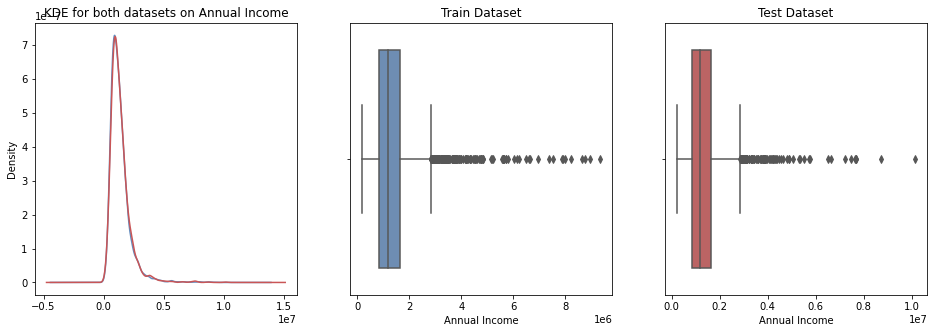

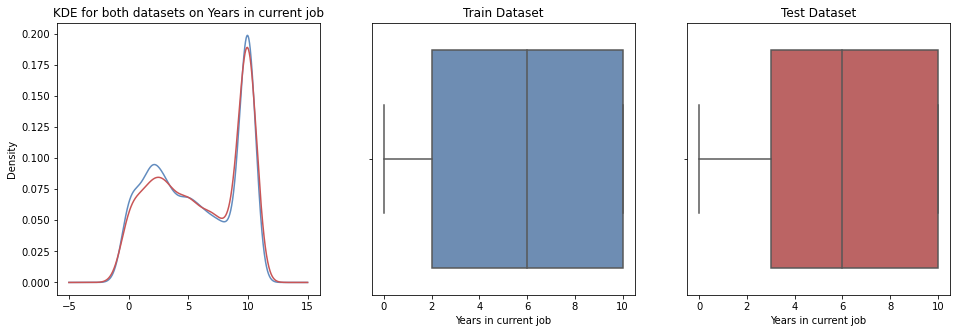

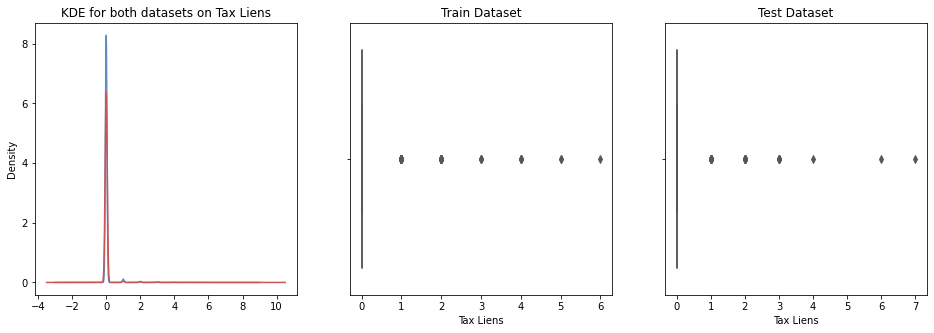

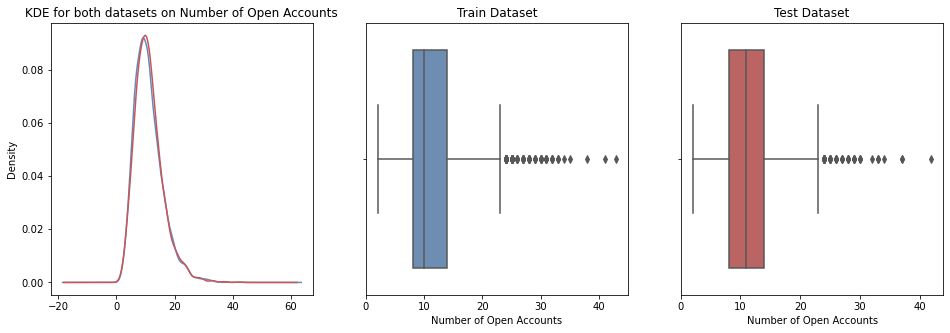

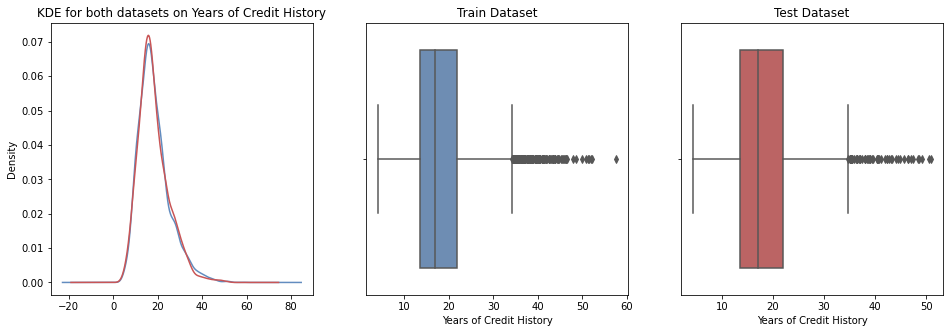

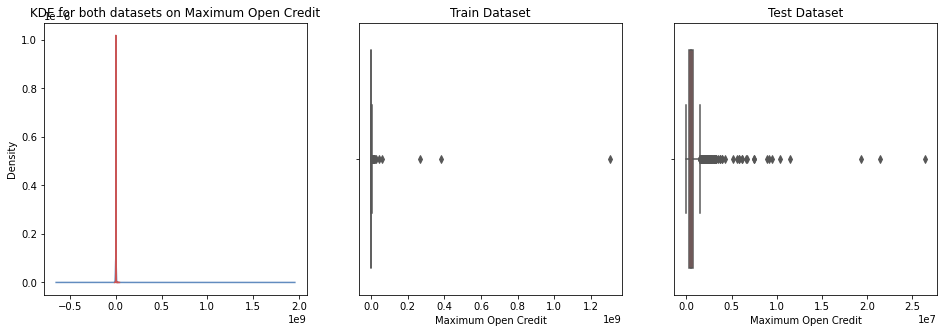

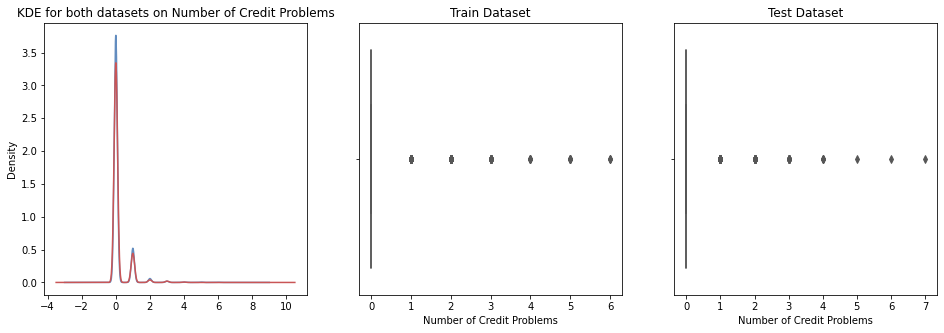

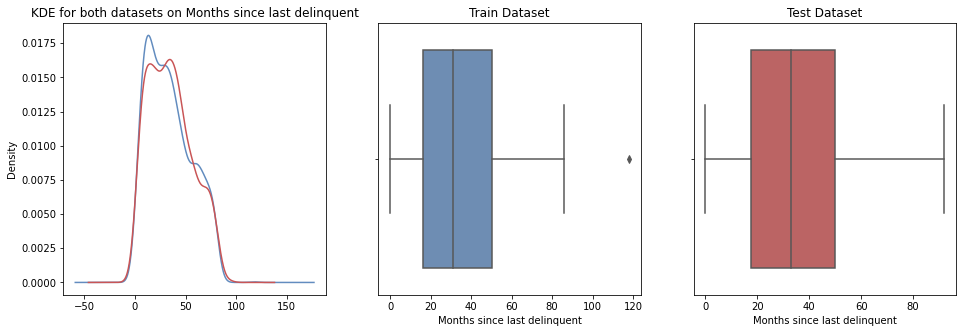

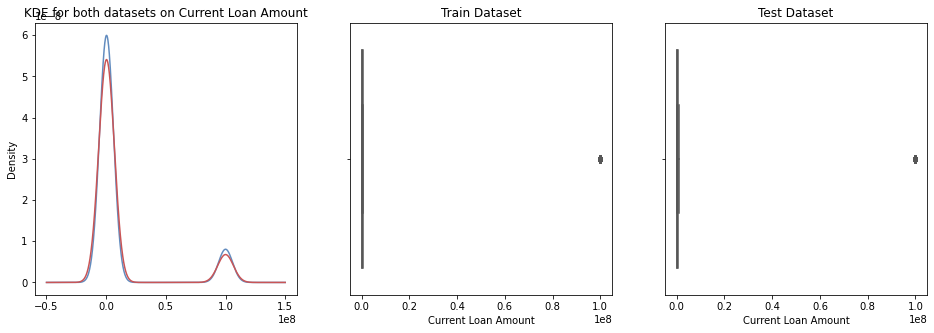

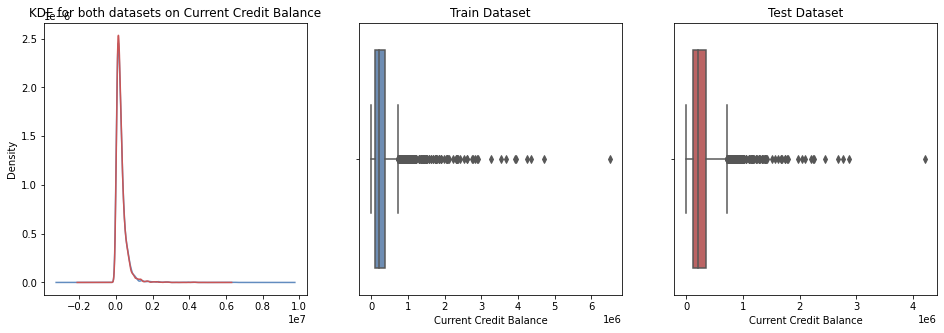

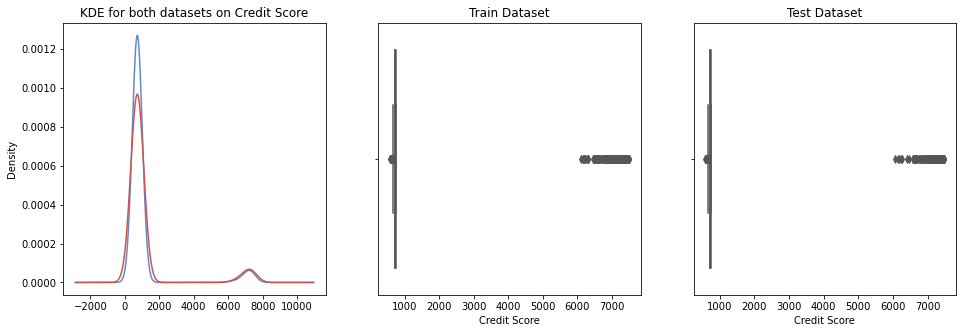

In [507]:
cont_cols = [
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Current Loan Amount',
    'Current Credit Balance',
    'Credit Score']

cat_cols =['Home Ownership',
           'Bankruptcies',
           'Purpose',
           'Term']

TARGET = ['Credit Default']



for col_name in cont_cols:
    plot_outliers(train_full, test_full, col_name)

#### Выводы из визуального анализа:
* В целом графики KDE похожи
* Возможно есть выбросы сверху, особо заметные из них:
    * Диапазон значений в тестовых датасетах признаков **'Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems'** шире чем в тренировочных
    * В обоих датасетах признака **'Current Loan Amount'** есть много одинаковых больших значений
    * В обоих датасетах признака **'Credit Score'** есть много одинаковых больших значений
    
Рассмотрим каждый из пунктов по отдельности

### Обработка выбросов<a class="anchor" id="outliers"></a>

#### Признаки **'Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems'**
**--- TODO_1 ---**

#### Признак "Current Loan Amount"

In [508]:
print(train_full.loc[(train_full["Current Loan Amount"] == 99999999), :].shape)
print(test_full.loc[(test_full["Current Loan Amount"] == 99999999), :].shape)

(592, 17)
(278, 16)


Данный признак имеет много значений 99999999, скорее всего это выброс (ближайшее значение меньше 800000). Заменим эти значения медианными в обоих датасетах

In [509]:
train_full.loc[train_full['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = train_full['Current Loan Amount'].median()
test_full.loc[test_full['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = test_full['Current Loan Amount'].median()

Проверим результат замены:

In [510]:
print(train_full.loc[(train_full["Current Loan Amount"] == 99999999), :].shape)
print(test_full.loc[(test_full["Current Loan Amount"] == 99999999), :].shape)

(0, 17)
(0, 16)


#### Признак "Credit Score"

In [511]:
print(train_full.loc[(train_full["Credit Score"] > 850 ), "Credit Score"].shape)
print(test_full.loc[(test_full["Credit Score"] > 850 ), "Credit Score"].shape)

(242,)
(158,)


Данный признак имеет много значений больше 850 (850 - максимальный кредитный рейтинг по всем найденным шкалам). Все такие значения больше 6000, скорее всего это выброс. Проверим эти значения:

In [512]:
train_full.loc[(train_full["Credit Score"] > 6000 ), "Credit Score"]

69      6470.0
87      7440.0
94      7010.0
96      7320.0
116     7390.0
         ...  
4911    7460.0
4936    7170.0
4945    6180.0
4956    7160.0
4957    7170.0
Name: Credit Score, Length: 242, dtype: float64

Замечено, что многие значения оканчиваются на 0. Возможно он лишний, проверим все выбросные значения.
Функция _check_credit_score_outliers_ проверяет значения выбросов, б**о**льших 850. Предполагается, что в эти значения дописан лишний 0:

In [513]:
def check_credit_score_outliers(df):
    x = []
    for i in df.loc[(df["Credit Score"] > 850 ), "Credit Score"]:
        if i % 10 != 0:
            x.append(i)
    print(len(x))

In [514]:
check_credit_score_outliers(train_full)
check_credit_score_outliers(test_full)

0
0


 Таким образом, все выбросные значения оканчиваются на 0. Поделим все эти значения на 10:

In [515]:
train_full.loc[train_full['Credit Score'] > 850, 'Credit Score'] = train_full.loc[train_full['Credit Score'] > 850, 'Credit Score'] / 10
test_full.loc[test_full['Credit Score'] > 850, 'Credit Score'] = test_full.loc[test_full['Credit Score'] > 850, 'Credit Score'] / 10

Проверим описательные характеристики после проведенных преобразований:

In [516]:
test_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,2002.0,1.382640e+06,8.533618e+05,216714.0,859811.75,1168528.5,1659787.75,10149344.0
Years in current job,2388.0,6.028057e+00,3.598464e+00,0.0,3.00,6.0,10.00,10.0
Tax Liens,2500.0,3.040000e-02,2.951452e-01,0.0,0.00,0.0,0.00,7.0
Number of Open Accounts,2500.0,1.122680e+01,4.866625e+00,2.0,8.00,11.0,14.00,42.0
Years of Credit History,2500.0,1.823820e+01,6.919173e+00,4.3,13.60,17.0,22.00,51.0
Maximum Open Credit,2500.0,6.769239e+05,1.066010e+06,0.0,282012.50,466081.0,783706.00,26406996.0
Number of Credit Problems,2500.0,1.640000e-01,4.943701e-01,0.0,0.00,0.0,0.00,7.0
Months since last delinquent,1135.0,3.517709e+01,2.146659e+01,0.0,17.50,33.0,50.00,92.0
Bankruptcies,2497.0,1.117341e-01,3.360225e-01,0.0,0.00,0.0,0.00,4.0
Current Loan Amount,2500.0,3.093576e+05,1.685120e+05,21516.0,180246.00,311481.5,404569.00,788480.0


In [517]:
def plot_outliers_cat(df_tr,df_te, col_name):
    fig, ax = plt.subplots(1,2,figsize=(16,5))
   
    ax[0].set_title('Train Dataset')
    ax[1].set_title('Test Dataset')   

    sns.countplot(x=col_name, data=df_tr, ax=ax[0]);
    sns.countplot(x=col_name, data=df_te, ax=ax[1]);
    plt.show()

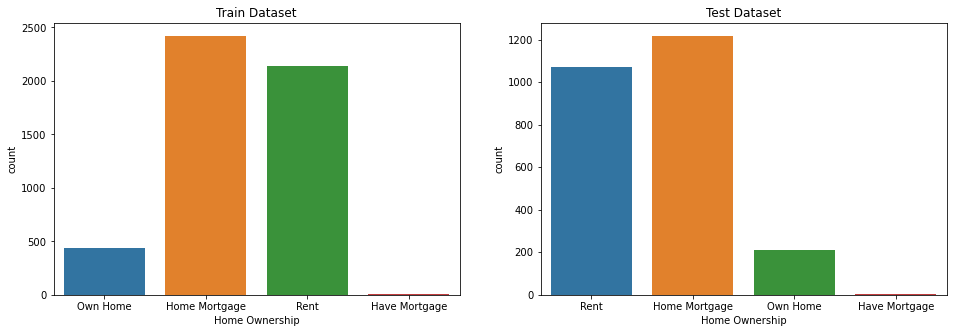

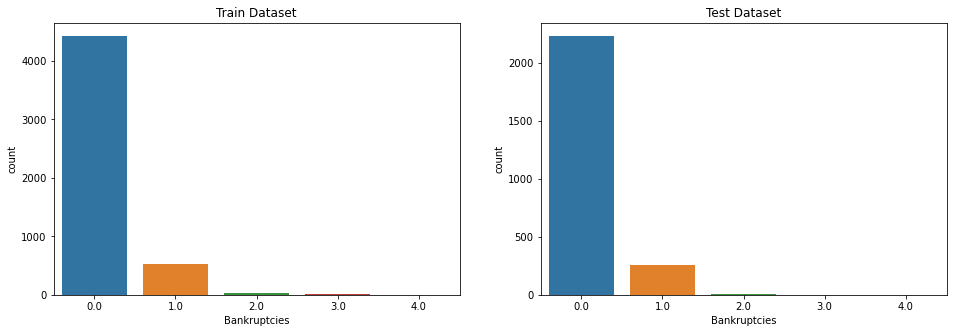

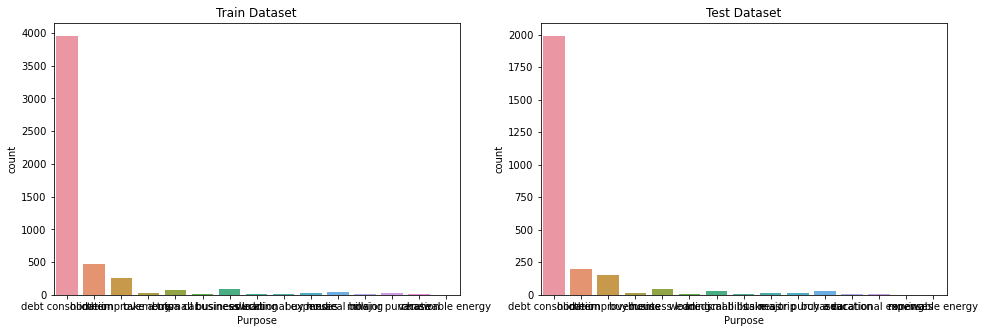

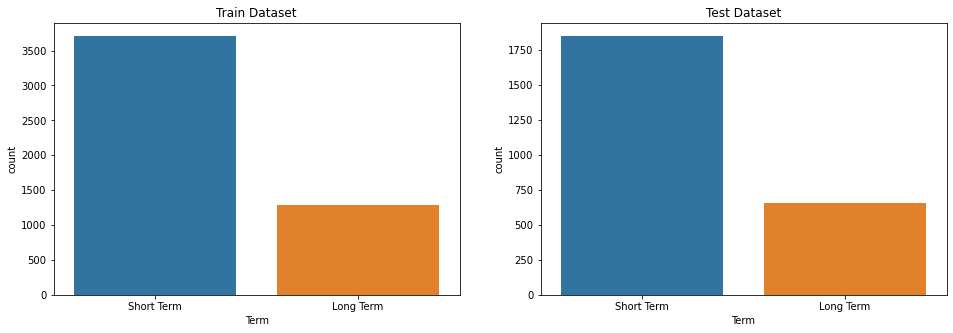

In [518]:
for col_name in cat_cols:
    plot_outliers_cat(train_full,test_full, col_name)

В целом гистограммы однородны и похожи у датасетов

## Обработка пропусков

### Признаки с пропусками

In [434]:
print(f"TRAIN:\n{train_pass_features}")
print(f"TEST:\n{test_pass_features}")

TRAIN:
{'Annual Income': 1059, 'Years in current job': 259, 'Months since last delinquent': 2716, 'Bankruptcies': 11, 'Credit Score': 1059}
TEST:
{'Annual Income': 498, 'Years in current job': 112, 'Months since last delinquent': 1365, 'Bankruptcies': 3, 'Credit Score': 498}


#### Признаки 'Annual Income', ' Credit Score', 'Years in current job', 'Bankruptcies'
Признаки Annual Income' и 'Credit Score' имеют пропуски в одинаковых позициях:

In [435]:
train_annual_income_nan_idx = train_full.index[train_full['Annual Income'].isna()]
train_credit_score_nan_idx = train_full.index[train_full['Credit Score'].isna()]
if sorted(train_annual_income_nan_idx) == sorted(train_credit_score_nan_idx):
    print('ID совпадают')

ID совпадают


Заполним пропуски данных признаков медианными значениями:

In [436]:
# Медианы
annual_income_median = train_full['Annual Income'].median()
credit_score_median = train_full['Credit Score'].median()
years_in_current_job_median = train_full['Years in current job'].median()
bankruptcies_median = train_full['Bankruptcies'].median()

In [437]:
# Замена
train_full.loc[train_full['Annual Income'].isna(), 'Annual Income'] = annual_income_median
train_full.loc[train_full['Credit Score'].isna(), 'Credit Score'] = credit_score_median
train_full.loc[train_full['Years in current job'].isna(), 'Years in current job'] = years_in_current_job_median
train_full.loc[train_full['Bankruptcies'].isna(), 'Bankruptcies'] = bankruptcies_median

test_full.loc[test_full['Annual Income'].isna(), 'Annual Income'] = annual_income_median
test_full.loc[test_full['Credit Score'].isna(), 'Credit Score'] = credit_score_median
test_full.loc[test_full['Years in current job'].isna(), 'Years in current job'] = years_in_current_job_median
test_full.loc[test_full['Bankruptcies'].isna(), 'Bankruptcies'] = bankruptcies_median

Попробовать регрессию  
**--- TODO_2 ---**

#### Признак 'Months since last delinquent'
Данный имеет пропуски более чем 50%, предлагается удалить этот признак

In [438]:
train_full.drop(['Months since last delinquent'], axis=1, inplace=True)
test_full.drop(['Months since last delinquent'], axis=1, inplace=True)

In [439]:
cont_cols.remove('Months since last delinquent')

Проверка пропусков после их удаления в обоих датасетах:

In [440]:
print(f'Число пропусков в TRAIN: {train_full.isna().sum().sum()}')
print(f'Число пропусков в TRAIN: {test_full.isna().sum().sum()}')

Число пропусков в TRAIN: 0
Число пропусков в TRAIN: 0


## Анализ на возможность объединения признаков

In [441]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [442]:
train_full['ID'] = train_full.index
test_full['ID'] = test_full.index

In [443]:
def CHi_check(df, col, list_samp=None):
#     print(f"col: {col}")
    p = 0
    df_isin_samp = df[col].isin(list_samp)
    numb_sample = np.sum(df_isin_samp)
#     print(numb_sample)
    if numb_sample > 500:
#         numb_sample = 500
#         if numb_sample > 50:
        col_and_target_s = df.loc[df_isin_samp, ['ID', col, TARGET_NAME]].sample(500)
#         print(col_and_target_s) 
        table = col_and_target_s.pivot_table(values='ID', index=col, columns=TARGET_NAME, aggfunc='count')
#         print(table)

        chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p

In [444]:
alph = 0.05
for col in cat_cols:
    f_uniq = train_full[col].unique()
    #print(col,': ',f_uniq)
    for i in f_uniq:
        for j in f_uniq:
            if i != j:
                p = CHi_check(train_full, col, list_samp=[i,j])
                if p > alph:
                    print(f"{col}: [{i}, {j}] - {p}")

Home Ownership: [Own Home, Home Mortgage] - 0.12839425745392327
Home Ownership: [Own Home, Rent] - 0.7184899128629452
Home Ownership: [Home Mortgage, Own Home] - 0.24628055687892753
Home Ownership: [Home Mortgage, Rent] - 0.8726673232062045
Home Ownership: [Rent, Own Home] - 0.43168438382406094
Home Ownership: [Rent, Home Mortgage] - 0.10582928367669465
Home Ownership: [Rent, Have Mortgage] - 1.0
Purpose: [debt consolidation, other] - 0.5728374240690126
Purpose: [debt consolidation, home improvements] - 0.5500874729524872
Purpose: [debt consolidation, take a trip] - 0.9070226270172144
Purpose: [debt consolidation, buy a car] - 0.08615856647226879
Purpose: [debt consolidation, small business] - 0.5021767687528843
Purpose: [debt consolidation, business loan] - 0.3502854393434607
Purpose: [debt consolidation, wedding] - 1.0
Purpose: [debt consolidation, educational expenses] - 1.0
Purpose: [debt consolidation, medical bills] - 0.4874784736838039
Purpose: [debt consolidation, moving] - 0.4

Можно объединить Purpose: [renewable energy, debt consolidation]  
**--- TODO_3 ---**

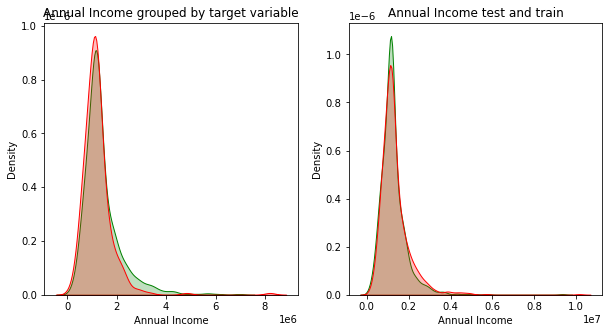

ShapiroResult(statistic=0.7657562494277954, pvalue=1.8814464371694877e-35)


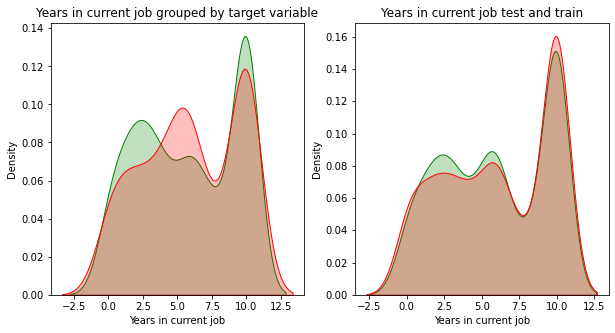

ShapiroResult(statistic=0.8817852735519409, pvalue=6.504994017143106e-27)


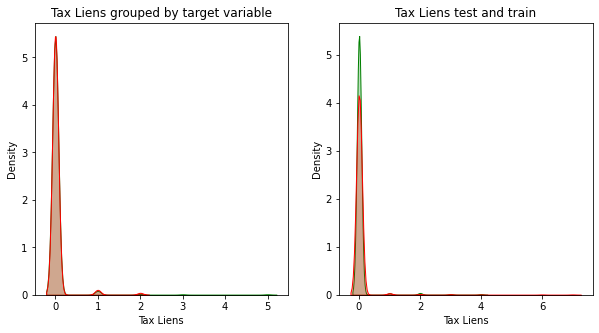

ShapiroResult(statistic=0.09666848182678223, pvalue=0.0)


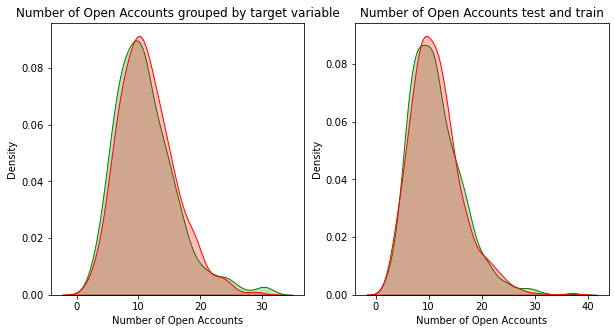

ShapiroResult(statistic=0.940996527671814, pvalue=1.6780125160174485e-19)


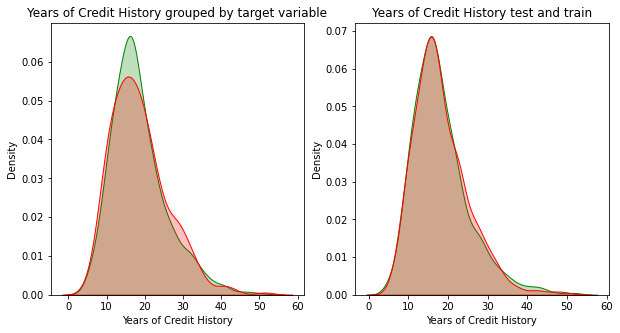

ShapiroResult(statistic=0.9246312975883484, pvalue=5.743587451218139e-22)


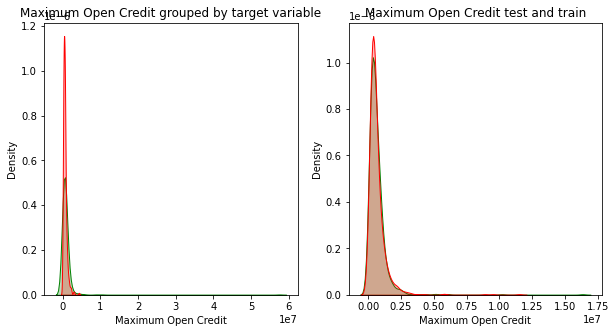

ShapiroResult(statistic=0.45908886194229126, pvalue=0.0)


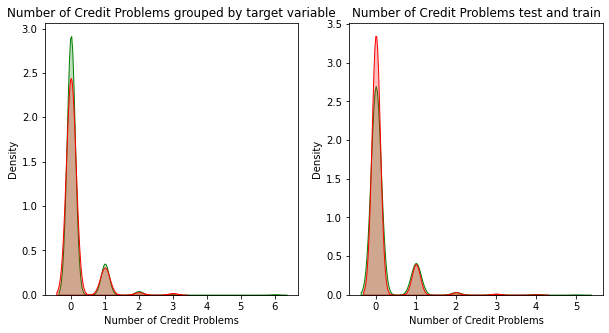

ShapiroResult(statistic=0.39843636751174927, pvalue=0.0)


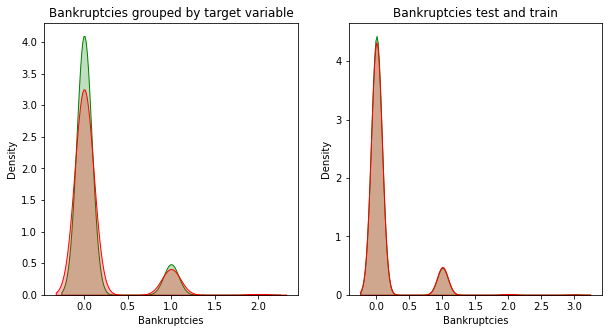

ShapiroResult(statistic=0.3394755721092224, pvalue=0.0)


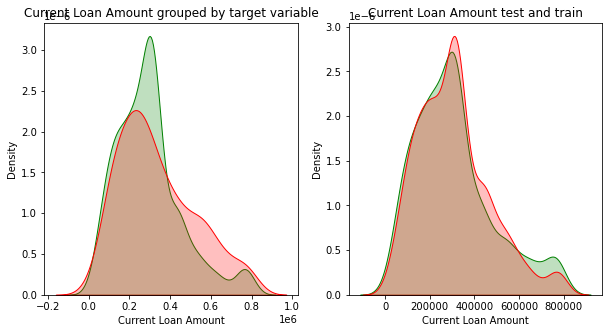

ShapiroResult(statistic=0.9314308166503906, pvalue=5.372863619339394e-21)


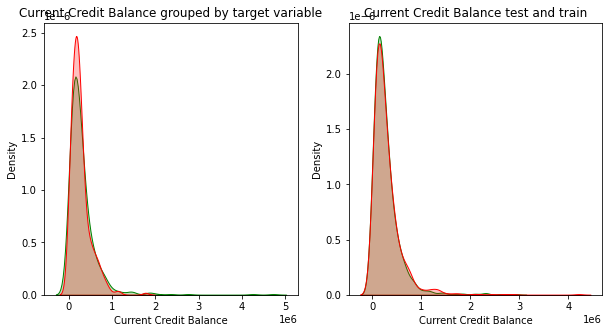

ShapiroResult(statistic=0.6680430769920349, pvalue=2.7866781780949042e-40)


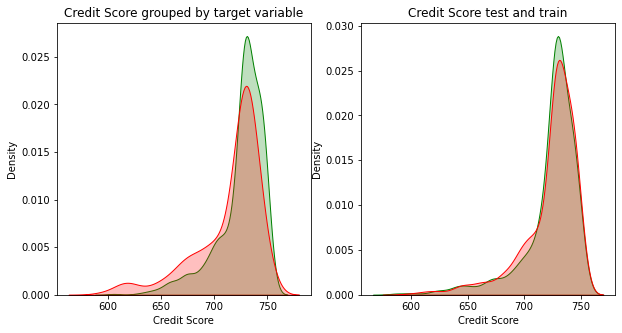

ShapiroResult(statistic=0.771190881729126, pvalue=3.873382742639984e-35)


In [445]:
for col in cont_cols:
    plt.figure(figsize=(10, 5))
    col_with_target_s = train_full[[col, TARGET_NAME]].sample(1000)
    col_s = col_with_target_s[col]
    col_target_0 = col_s[col_with_target_s[TARGET_NAME] == 0]
    col_target_1 = col_s[col_with_target_s[TARGET_NAME] == 1]

    
    plt.subplot(1,2,1)
    sns.kdeplot(col_target_0, shade=True, label=0, color='g', legend=True)
    sns.kdeplot(col_target_1, shade=True, label=1, color='r', legend=True)
    
    plt.xlabel(col)
    plt.title(col+' grouped by target variable')
    
    col_s = train_full[col ].sample(1000)
    col_st = test_full[col ].sample(1000)

    
    plt.subplot(1,2,2)
    sns.kdeplot(col_s, shade=True, label='train', color='g', legend=True)
    sns.kdeplot(col_st, shade=True, label='test', color='r', legend=True)
    
    plt.xlabel(col)
    plt.title(col+' test and train')
    
    plt.show()
    print(shapiro(col_s))

### Преобразование категориальных признаков
#### Категоризация

In [446]:
cols_to_cat = cat_cols
for col in cols_to_cat:
    train_full[col] = train_full[col].astype("category")
    test_full[col] = test_full[col].astype("category")

### Анализ целевой переменной и корреляции

#### Целевая переменная

In [447]:
y_train.value_counts()

0    3617
1    1383
Name: Credit Default, dtype: int64

#### Корелляционный анализ

In [451]:
X_test['Bankruptcies'].unique()

array([0., 1., 2., 3., 4.])

{'Bankruptcies - Number of Credit Problems': 0.7479015410908275,
 'Number of Credit Problems - Bankruptcies': 0.7479015410908275,
 'Home Ownership_Rent - Home Ownership_Home Mortgage': -0.8360542454291362,
 'Home Ownership_Home Mortgage - Home Ownership_Rent': -0.8360542454291362}

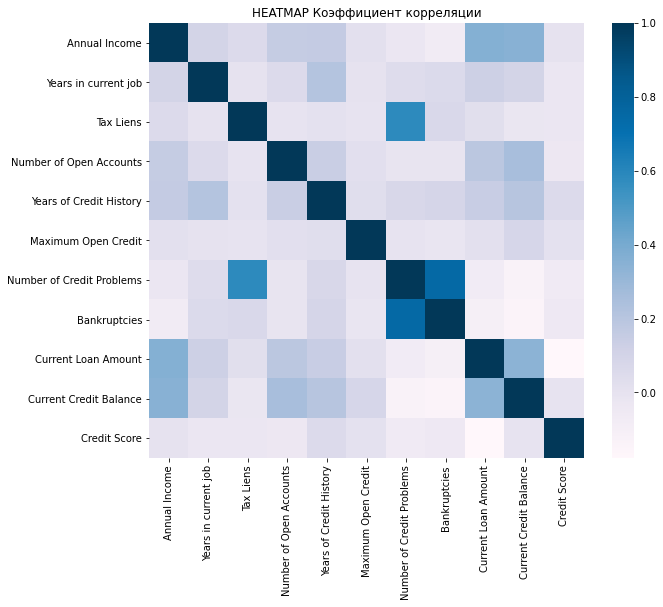

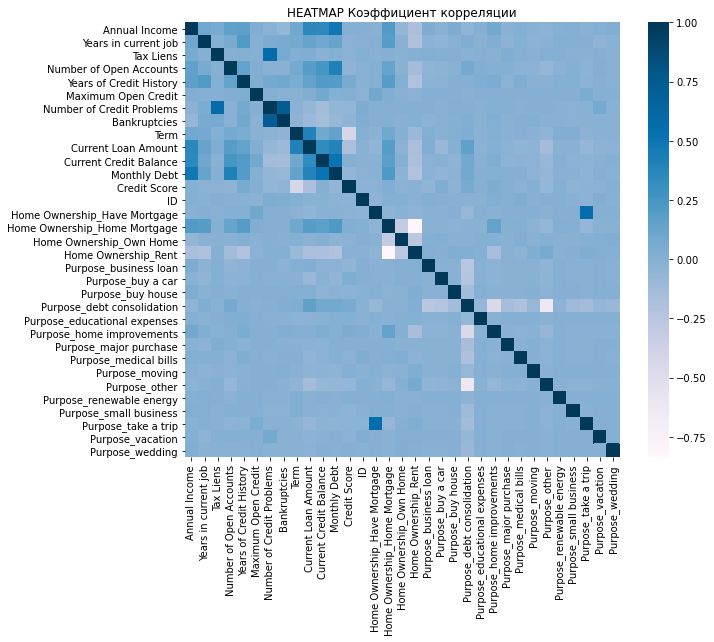

In [448]:
cols_to_analyze = cont_cols

def plot_corr_map(corr_matrix):
#     plot given correlation matrix in heatmap style
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes()
    ax.set_title('HEATMAP Коэффициент корреляции')
    sns.heatmap(corr_matrix, square=True,ax=ax,cmap='PuBu');

# Корелляция непрерывных данных
corr_matrix = X_train[cols_to_analyze].corr()
plot_corr_map(corr_matrix)

# Корелляция всех признаков
corr_matrix = X_train.corr()
plot_corr_map(corr_matrix)

correlated_features = dict()
corr_threshold = 0.7

for col in corr_matrix.columns:
    for row in corr_matrix[col].index:
        if corr_threshold < abs(corr_matrix.loc[row, col]) < 1.0:
            pair = f'{row} - {col}'
            correlated_features[pair] = corr_matrix.loc[row, col]

display(correlated_features)

### Разделение датасетов для обучения

In [356]:
X_train = train_full.drop(columns=[TARGET_NAME], axis=1)
X_test = test_full.copy()

y_train = train_full[TARGET_NAME]

print(X_train.shape, X_test.shape, y_train.shape)

(5000, 16) (2500, 16) (5000,)


## Подбор гиперпараметров

In [357]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import itertools
from imblearn.pipeline import Pipeline as SM_Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

### Преобразование категориальных признаков в dummies

#### Преобразование значений категориальных признаков, имеющих только 2 значения, в 0 и 1. 

In [358]:
train_full.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)
test_full.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)
print(f"Значения признака \033[1mTerm\033[0m преобразованы в 0 и 1")

Значения признака Term преобразованы в 0 и 1


#### Преобразование значений категориальных признаков, имеющих более 2 значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Home Ownership             5000 non-null   category
 1   Annual Income              5000 non-null   float64 
 2   Years in current job       5000 non-null   float64 
 3   Tax Liens                  5000 non-null   int64   
 4   Number of Open Accounts    5000 non-null   int64   
 5   Years of Credit History    5000 non-null   float64 
 6   Maximum Open Credit        5000 non-null   int64   
 7   Number of Credit Problems  5000 non-null   int64   
 8   Bankruptcies               5000 non-null   float64 
 9   Purpose                    5000 non-null   category
 10  Term                       5000 non-null   int64   
 11  Current Loan Amount        5000 non-null   int64   
 12  Current Credit Balance     5000 non-null   int64   
 13  Monthly Debt               5000 n

In [367]:
def cat_to_dummies(df):
#     print(df)
    for feature in df.select_dtypes(include='category').columns:
        df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature)], axis=1)
        print(f"Значения признака \033[1m{feature}\033[0m преобразованы в DUMMIES")
    return df

In [373]:
train_full_1 = cat_to_dummies(train_full)
test_full_1 = cat_to_dummies(test_full)

Значения признака Home Ownership преобразованы в DUMMIES
Значения признака Purpose преобразованы в DUMMIES


In [378]:
train_full_1.select_dtypes(include='category').columns

Index(['Home Ownership', 'Purpose'], dtype='object')

In [395]:
X_train = train_full_1.drop(columns=[TARGET_NAME, 'Home Ownership', 'Purpose'], axis=1)
X_test = test_full_1.copy()
X_test = X_test.drop(columns=['Home Ownership', 'Purpose'], axis=1)
y_train = train_full_1[TARGET_NAME]
y_test = test_full_1[TARGET_NAME]

print(X_train.shape, X_test.shape, y_train.shape)

KeyError: 'Credit Default'

In [388]:
test_full_ans

5000    0
5001    1
5002    1
5003    0
5004    0
       ..
7495    0
7496    1
7497    0
7498    0
7499    0
Name: Credit Default, Length: 2500, dtype: int64

In [389]:
# ТЕСТОВОЕ ОБУЧЕНИЕ НА RFR
model_rfr = RandomForestRegressor(max_depth=16, n_estimators=175, random_state=123)
model_rfr.fit(X_train, y_train)
predict_1 = model_rfr.predict(X_test)
# f1_score(test_full_ans, predict_1)

In [393]:
from sklearn.metrics import r2_score as r2, accuracy_score

In [394]:
r2(test_full_ans, predict_1)

0.02135888218428217

#### Построим матрицу корреляций, чтобы проверить  наличие линейных связей между признаками
### Матрица корреляций

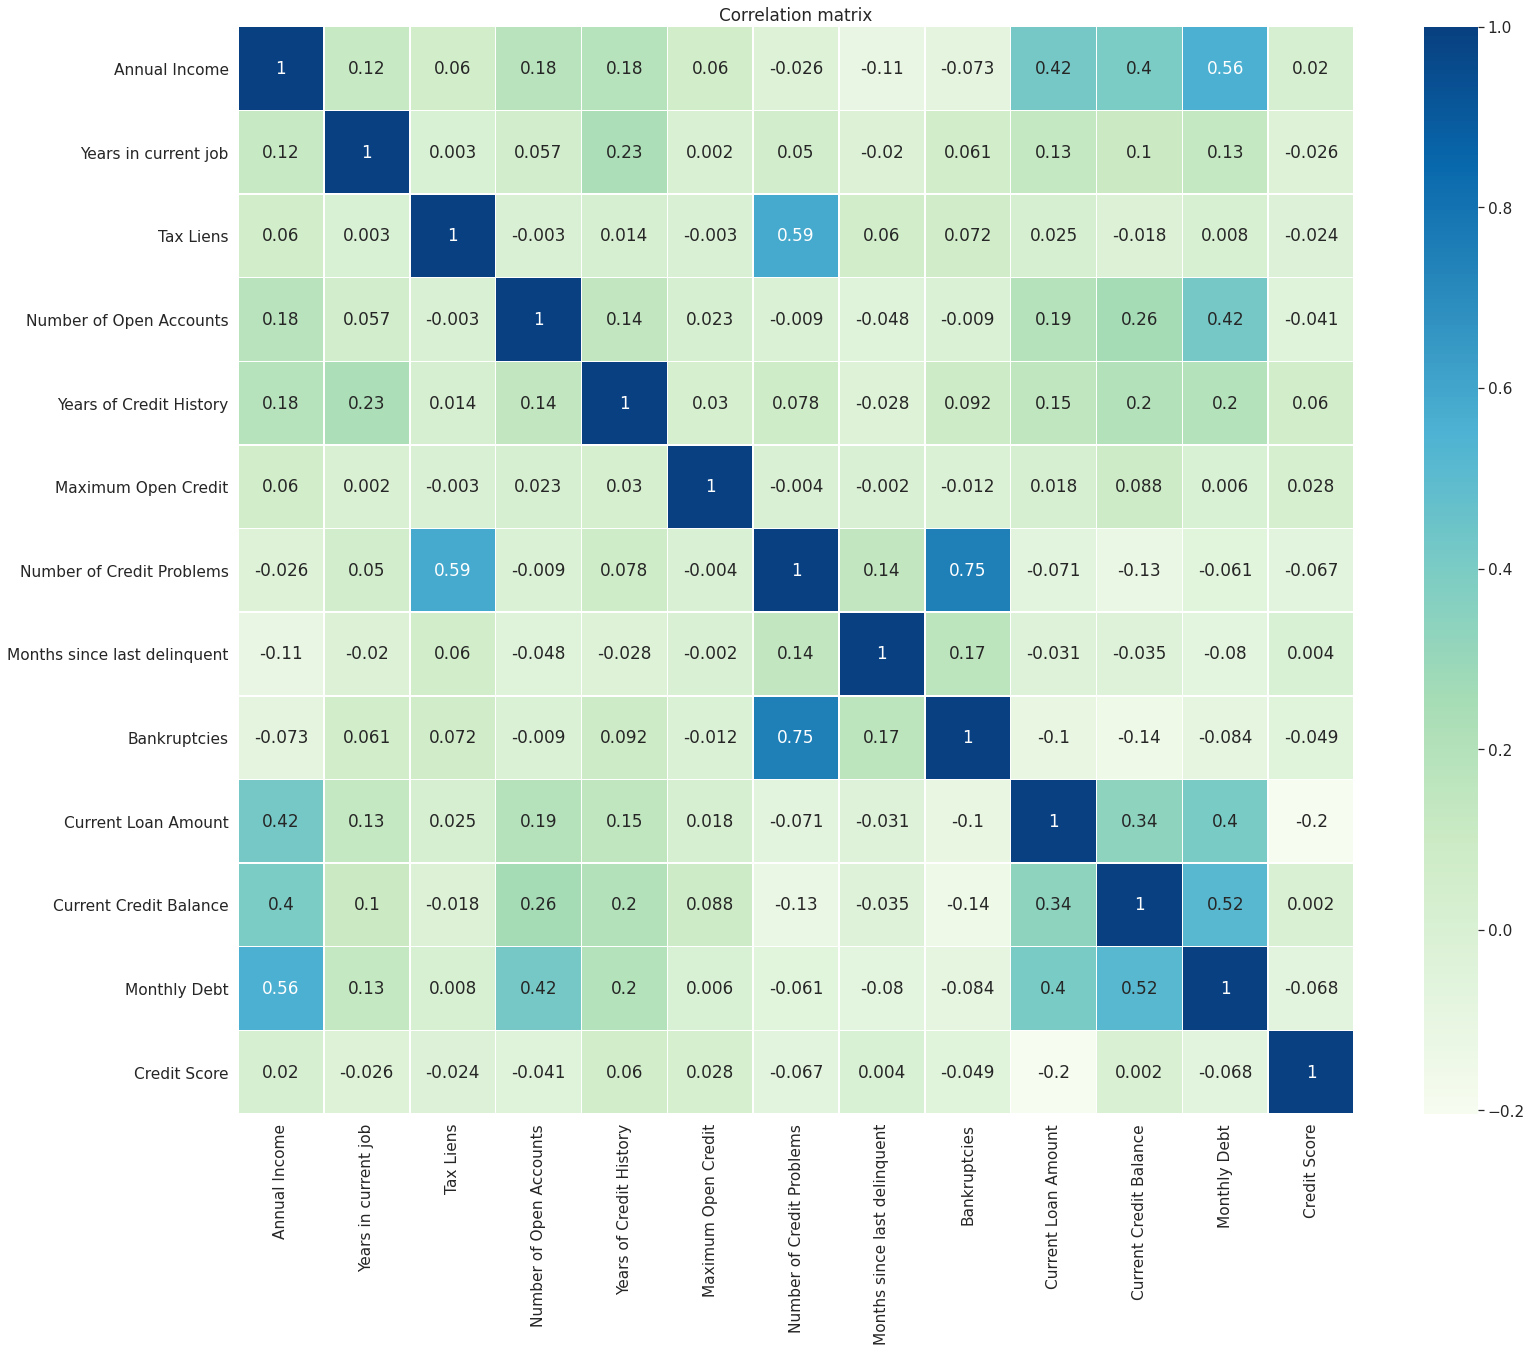

In [261]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train_full[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Подбор значений признака "Annual Income"
Из матрицы видно, что данный признак корелирует с признаком "Monthly Debt". Признак "Monthly Debt" не имеет пропусков. Применим линейную регрессию для подбора значений "Annual Income"

In [ ]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'])], axis=1)
df_train.columns